# Setup 

In [26]:
from collections import Counter
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv("chess_king_rook_dataset.csv")

## Understanding Data

In [3]:
df.dtypes

white_king_file    object
white_king_rank     int64
white_rook_file    object
white_rook_rank     int64
black_king_file    object
black_king_rank     int64
result             object
dtype: object

In [4]:
df['white_king_rank'].unique(), df['white_rook_rank'].unique()

(array([1, 2, 3, 4], dtype=int64),
 array([3, 1, 2, 4, 5, 6, 7, 8], dtype=int64))

Should we keep the rank variable numeric? Seems more categorical (ie 1, 2, etc are row names, not a true continuous variable like height or weight)

In [5]:
df['result'].unique()

array(['draw', 'zero', 'one', 'two', 'three', 'four', 'five', 'six',
       'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'thirteen',
       'fourteen', 'fifteen', 'sixteen'], dtype=object)

In [6]:
df.shape

(28056, 7)

draw is a draw, numbers are # of turns to a win

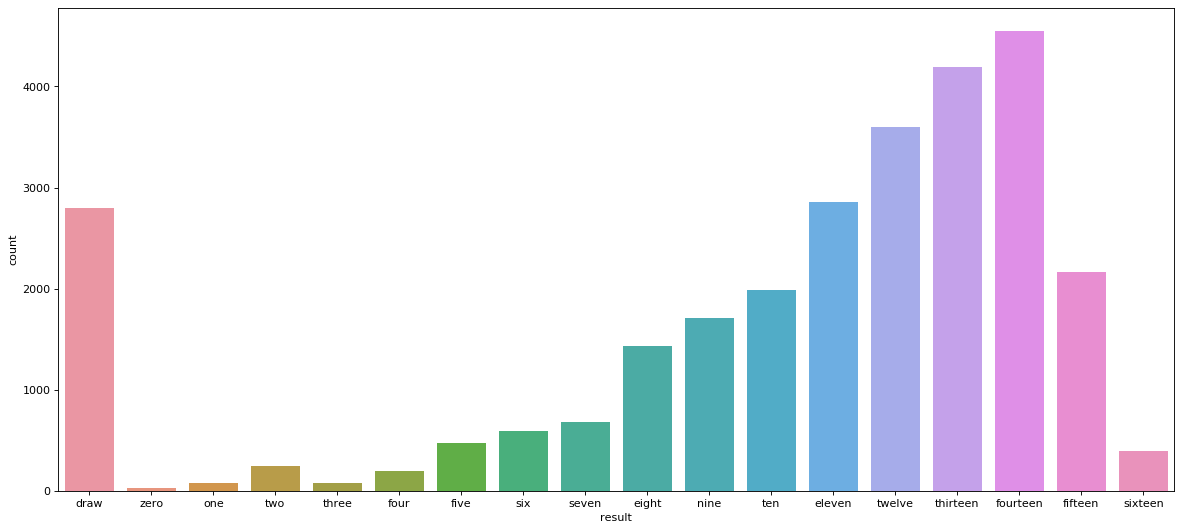

In [7]:
plt.figure(figsize=(18, 8), dpi=80)
sns.countplot(data=df, x='result')

In [8]:
# binary result fits with Santorini (draws aren't possible in that game)
df['win'] = df['result'] != 'draw'
df['win'] = df['win'].astype(int)

In [9]:
df.win.mean() #90%ish are wins

0.9003421727972626

## Create series of dummy variables for columns

In [10]:
for col in df.columns:
    if "rank" in col:
        df[col] = df[col].astype(str)

df.dtypes

white_king_file    object
white_king_rank    object
white_rook_file    object
white_rook_rank    object
black_king_file    object
black_king_rank    object
result             object
win                 int32
dtype: object

In [11]:
dummy_df = copy.deepcopy(df)
del dummy_df['result']

In [12]:
dummy_df = pd.get_dummies(dummy_df)
dummy_df['result'] = df['result']

In [13]:
dummy_df.head()

,win,white_king_file_a,white_king_file_b,white_king_file_c,white_king_file_d,white_king_rank_1,white_king_rank_2,white_king_rank_3,white_king_rank_4,white_rook_file_a,...,black_king_file_h,black_king_rank_1,black_king_rank_2,black_king_rank_3,black_king_rank_4,black_king_rank_5,black_king_rank_6,black_king_rank_7,black_king_rank_8,result
0,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,draw
1,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,draw
2,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,draw
3,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,draw
4,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,draw


Quick check: what variables are statisitcally significant?

In [14]:
formula_str = 'win ~ '
col_list = []
for col in df.columns:
    if col != 'result' and col != 'win':
        formula_str += col + ' + '
        col_list.append(col)
    
formula_str = formula_str[0:len(formula_str) - 3] # remove last plus sign    
print(formula_str)

probit_model = smf.probit(data = df, formula = formula_str).fit()
probit_model.summary()

win ~ white_king_file + white_king_rank + white_rook_file + white_rook_rank + black_king_file + black_king_rank
Optimization terminated successfully.
         Current function value: 0.312907
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                28056
Model:                         Probit   Df Residuals:                    28021
Method:                           MLE   Df Model:                           34
Date:                Sun, 06 Jun 2021   Pseudo R-squ.:                 0.03522
Time:                        11:15:35   Log-Likelihood:                -8778.9
converged:                       True   LL-Null:                       -9099.4
Covariance Type:            nonrobust   LLR p-value:                4.021e-113
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.1759      0.076     28.506      0.000       2.026       2.326
white_king_file[T.b]     0.0115      0.047      0.243      0.808      -0.081       0.105
white_king_file[T.c]     0.0212      0.047      0.451      0.652      -0.071       0.113
white_king_file[T.d]     0.0262      0.048      0.550      0.583      -0.067       0.120
white_king_rank[T.2]     0.0149      0.026      0.583      0.560      -0.035       0.065
white_king_rank[T.3]     0.0296      0.032      0.918      0.359      -0.034       0.093
white_king_rank[T.4]     0.0138      0.051      0.272      0.785      -0.086       0.113
white_rook_file[T.b]    -0.2029      0.047     -4.362      0.000      -0.294      -0.112
white_rook_file[T.c]    -0.1241      0.048     -2.605      0.009      -0.217      -0.031
white_rook_file[T.d]    -0.2131      0.047     -4.554      0.000      -0.305      -0.121
white_rook_file[T.e]    -0.3218      0.045     -7.128      0.000      -0.410      -0.233
white_rook_file[T.f]    -0.4753      0.044    -10.817      0.000      -0.561      -0.389
white_rook_file[T.g]    -0.5679      0.043    -13.123      0.000      -0.653      -0.483
white_rook_file[T.h]    -0.2872      0.045     -6.341      0.000      -0.376      -0.198
white_rook_rank[T.2]    -0.2224      0.045     -4.974      0.000      -0.310      -0.135
white_rook_rank[T.3]    -0.2362      0.045     -5.298      0.000      -0.324      -0.149
white_rook_rank[T.4]    -0.3213      0.044     -7.325      0.000      -0.407      -0.235
white_rook_rank[T.5]    -0.3485      0.044     -7.985      0.000      -0.434      -0.263
white_rook_rank[T.6]    -0.3285      0.044     -7.490      0.000      -0.414      -0.243
white_rook_rank[T.7]    -0.3031      0.044     -6.873      0.000      -0.389      -0.217
white_rook_rank[T.8]    -0.0067      0.047     -0.141      0.887      -0.100       0.086
black_king_file[T.b]    -0.2303      0.048     -4.840      0.000      -0.324      -0.137
black_king_file[T.c]    -0.2083      0.049     -4.214      0.000      -0.305      -0.111
black_king_file[T.d]    -0.2014      0.048     -4.196      0.000      -0.295      -0.107
black_king_file[T.e]    -0.2078      0.046     -4.517      0.000      -0.298      -0.118
black_king_file[T.f]    -0.2111      0.044     -4.781      0.000      -0.298      -0.125
black_king_file[T.g]    -0.2537      0.044     -5.829      0.000      -0.339      -0.168
black_king_file[T.h]     0.0306      0.045      0.673      0.501      -0.059       0.120
black_king_rank[T.2]    -0.2603      0.045     -5.830      0.000      -0.348      -0.173
black_king_rank[T.3]    -0.2373      0.044     -5.366      0.000      -0.324      -0.151
black_king_rank[T.4]    -0.2753      0.043     -6.357      0.000      -0.360      -0.190
black_king_rank[T.5]    -0.2972      0.043     -6.902      0.000      -0.382      -0.213
black_king_rank[T.6]    -0.3129      0.044     -7.181      0.000      -0.398      -0.228
black_king_rank[T.7]    -0.3370      

white king's ocation seem's meaningless, most of everything else is meaningful

Multinomial probit on result variable is also possible, but would have 17 different models, not very readable

# Sklearn - No Parameter Tuning, No Scaling

Won't have time to analyze individual boards in Santorini. Will need to rely on on predictions

## Data Setup

In [15]:
col_list = []
for col in dummy_df.columns:
    if col != 'win' and col != 'result':
        col_list.append(col)

X = dummy_df.loc[:, col_list]
y = dummy_df['win']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [16]:
Counter(y_test)

Counter({1: 5053, 0: 559})

Next piece will remain commented out. Don't need to scale binary variables. But good practice to do it anyway

In [17]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [18]:
def get_predictions(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    y_pred_class = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    y_pred_prob = [elem[1] for elem in y_pred_prob]
    
    return y_pred_class, y_pred_prob

In [19]:
def analyze_accuracy(y_test, y_pred_prob, y_pred_class):
    naive_pred = [1 for i in range(len(y_pred_class))]
    
    ns_auc = roc_auc_score(y_test, naive_pred)
    md_auc = roc_auc_score(y_test, y_pred_prob)
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model   : ROC AUC=%.3f' % (md_auc))
    
    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True)
    plt.show()
    
    ns_fpr, ns_tpr, _ = roc_curve(y_test, naive_pred)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_prob)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [20]:
def plot_calibration(y_test, y_prob):
    fop, mpv = calibration_curve(y_test,y_prob, n_bins=10, normalize=True)
    # plot perfectly calibrated
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    plt.plot(mpv, fop, marker='.')
    plt.show()

## Model 1: Linear SVM

In [167]:
linear_svc = SVC(kernel='linear', random_state=0, probability = True)
y_pred_class, y_pred_prob = get_predictions(linear_svc, X_train, y_train, X_test)

No Skill: ROC AUC=0.500
Model   : ROC AUC=0.481


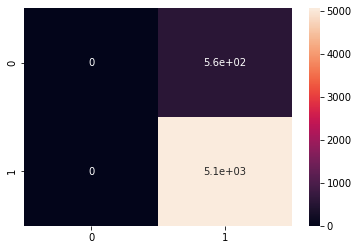

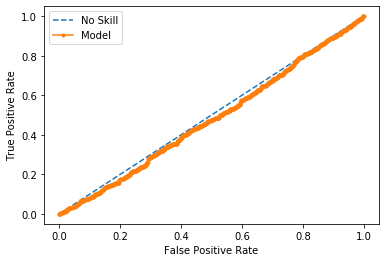

In [158]:
analyze_accuracy(y_test, y_pred_prob, y_pred_class)

SVM is worse than nothing!

# Model 2: Non-linear SVM

In [165]:
kernel_svc = SVC(kernel='rbf', gamma = 'auto', random_state=0, probability = True)
y_pred_class_rbf, y_pred_prob_rbf = get_predictions(kernel_svc, X_train, y_train, X_test)

No Skill: ROC AUC=0.500
Model   : ROC AUC=0.999


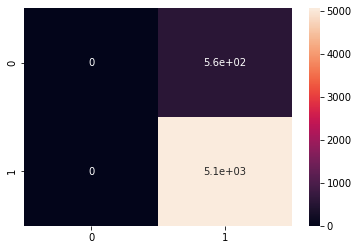

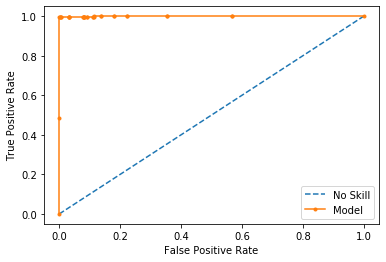

In [166]:
analyze_accuracy(y_test, y_pred_prob_rbf, y_pred_class_rbf)

What happened to the ROC curve? Separate note: model is still useless

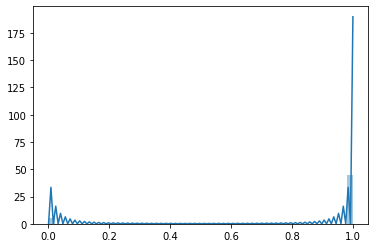

In [171]:
sns.distplot(y_pred_prob_rbf)

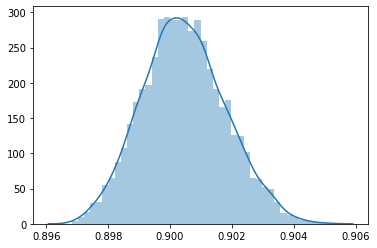

In [172]:
sns.distplot(y_pred_prob)

Kernel RBF predicts some low values. Linear RBF predicts ONLY high ones

## Model 3: Decision Trees - Bagging

In [22]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

y_pred_class_rf, y_pred_prob_rf = get_predictions(rf_model, X_train, y_train, X_test)

No Skill: ROC AUC=0.500
Model   : ROC AUC=0.999


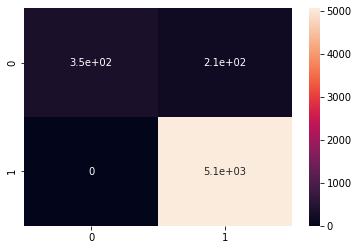

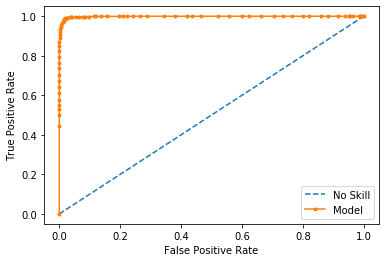

In [35]:
analyze_accuracy(y_test, y_pred_prob_rf, y_pred_class_rf)

Hey! Some correctly predicted 0s now!

## Model 4 - Decision Trees (Boosting)

In [27]:
from xgboost import XGBClassifier
xgb = XGBClassifier(booster='gbtree', random_state=0)

In [28]:
y_pred_class_xg, y_pred_prob_xg = get_predictions(xgb, X_train, y_train, X_test)

No Skill: ROC AUC=0.500
Model   : ROC AUC=1.000


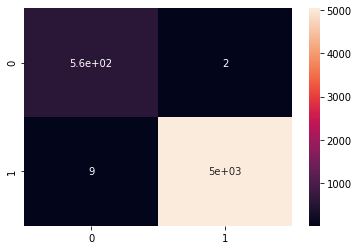

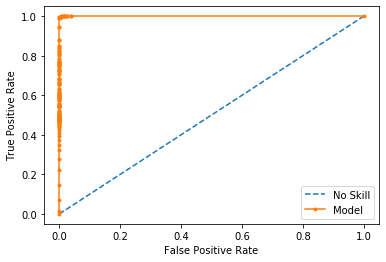

In [29]:
analyze_accuracy(y_test, y_pred_prob_xg, y_pred_class_xg)

Only 11 misses! Best model thus far. But I also want to look into parameter tuning

# Grid Search

Going to only look at kernel SVM since grid search takes very long

In [22]:
params = {'C': [10 ** n for n in range(-1,3)],
        'gamma' : [10 ** n for n in range(-2,1)],
        'kernel' : ['rbf']}
params

{'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1], 'kernel': ['rbf']}

In [23]:
grid_search_svc = GridSearchCV(estimator =SVC(random_state=0, probability = True),
                        param_grid = params,
                        cv = 4,
                        scoring = 'neg_log_loss',
                        n_jobs = -1,
                        verbose = 4)

In [24]:
y_pred_class_cv, y_pred_prob_cv = get_predictions(grid_search_svc, X_train, y_train, X_test)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 91.9min finished


No Skill: ROC AUC=0.500
Model   : ROC AUC=1.000


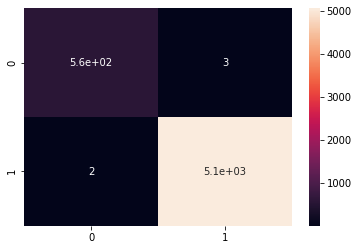

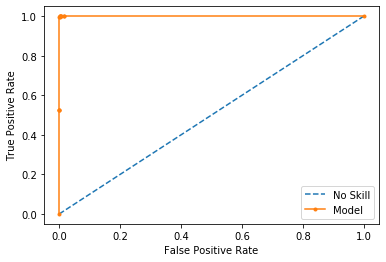

In [25]:
analyze_accuracy(y_test, y_pred_prob_cv, y_pred_class_cv)

Only 5 errors! But it took an hour and half to run

## Calibration

## Pre-Calibration

Classification is binary (in this case), did it pick the right group?
But we also might be interested in probability. What is the chance of a winning with this move?

Calibration means those percentages are accurate. For example, a move that gives a 70% chance of victory
should win about 70% of the time. If a win that shows a 70% chance of victory wins 99% of the time or 51% of
time, it would be an accurate prediction, but poorly calibrated

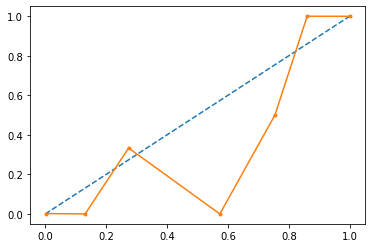

In [32]:
from sklearn.calibration import calibration_curve

plot_calibration(y_test, y_pred_prob_cv)

Doesn't look terribly well calibrated. Let's compare to some other models

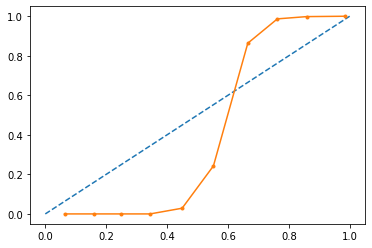

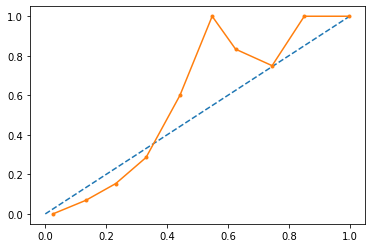

In [39]:
# Random Forest:
plot_calibration(y_test, y_pred_prob_rf)

#XG Boost
plot_calibration(y_test, y_pred_prob_xg)

XG Boost looks the best calibrated. But none are particularly great.

Two types of scaling
* Platt's scaling (i.e. sigmoid). Fits a logistic regression to predictions
* Monotonic regression (i.e. isotonic). Fits it to a piecewise constantly increasing model

In [23]:
rf_platt = CalibratedClassifierCV(rf_model, method = 'sigmoid')
rf_iso = CalibratedClassifierCV(rf_model, method = 'isotonic')

In [24]:
_ , pred_prob_platt = get_predictions(rf_platt, X_train, y_train, X_test)
_ , pred_prob_iso = get_predictions(rf_iso, X_train, y_train, X_test)

Original


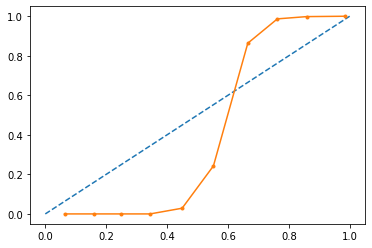

Platt Calibration


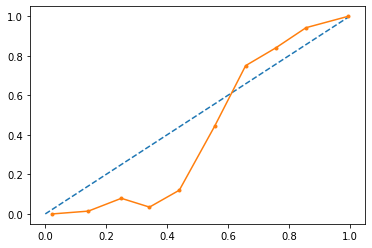

Isotonic Calibration


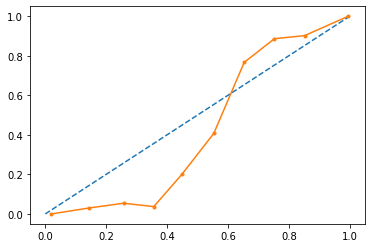

In [30]:
print("Original")
plot_calibration(y_test, y_pred_prob_rf)
print("Platt Calibration")
plot_calibration(y_test, pred_prob_platt)
print("Isotonic Calibration")
plot_calibration(y_test, pred_prob_iso)

Some noticeable change in calibrations

## Scaling - XG Boost

In [33]:
xg_platt = CalibratedClassifierCV(xgb, method = 'sigmoid')
xg_iso = CalibratedClassifierCV(xgb, method = 'isotonic')

In [34]:
_ , xg_prob_platt = get_predictions(xg_platt, X_train, y_train, X_test)
_ , xg_prob_iso = get_predictions(xg_iso, X_train, y_train, X_test)

Original


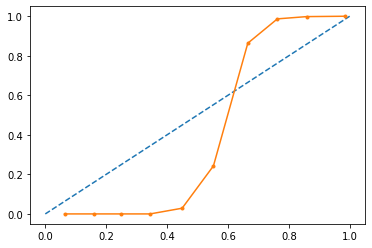

Platt Calibration


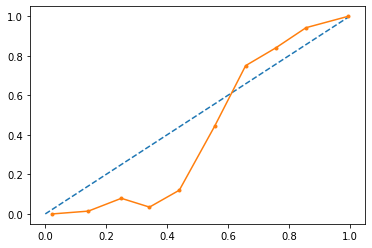

Isotonic Calibration


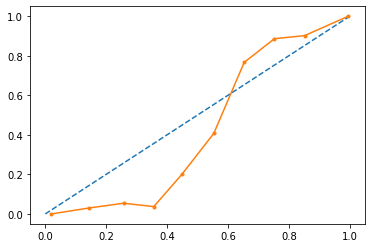

In [35]:
print("Original")
plot_calibration(y_test, y_pred_prob_rf)
print("Platt Calibration")
plot_calibration(y_test, pred_prob_platt)
print("Isotonic Calibration")
plot_calibration(y_test, pred_prob_iso)

# Extentions 

The techniques aboves are probably sufficient for this dataset.
However, I don't care about predicting chess moves, I want this to inform the Santorini AI.
As such, I will try two more pieces that help the Santorini project, but aren't needed here:

* Bayesian Optimization (an improvement on grid search)
* Deep Neural Networks (the models actually used by game AI's like AlphaZero)